# Coding a Blackhole Imager

In [1]:
import pandas as pd

# Load the file
filename = "M87_EHT_2013_amp.dat"

# Read the data
data = pd.read_csv(
    filename,
    comment='#',
    sep=r'\s*\|\s*',   # raw string fixes the warning
    engine='python',
    skip_blank_lines=True
)

# Drop completely empty rows and columns
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)

# Rename columns if needed
data.columns = ['time', 't1', 't2', 'u', 'v', 'amp', 'sigma']

print(data.head())
print(data.dtypes)


     time  t1  t2            u            v    amp   sigma
0  7.6667  AZ  C2 -574153920.0  359114592.0  0.744  0.0543
1  7.6667  AZ  C3 -574157888.0  359205376.0  0.744  0.0618
2  7.6667  C2  C3      -3970.0      90781.0  1.660  0.0652
3  8.3167  AZ  C2 -604271296.0  337487712.0  0.848  0.0589
4  8.3167  AZ  C3 -604285312.0  337578176.0  0.848  0.0656
time     float64
t1        object
t2        object
u        float64
v        float64
amp      float64
sigma    float64
dtype: object


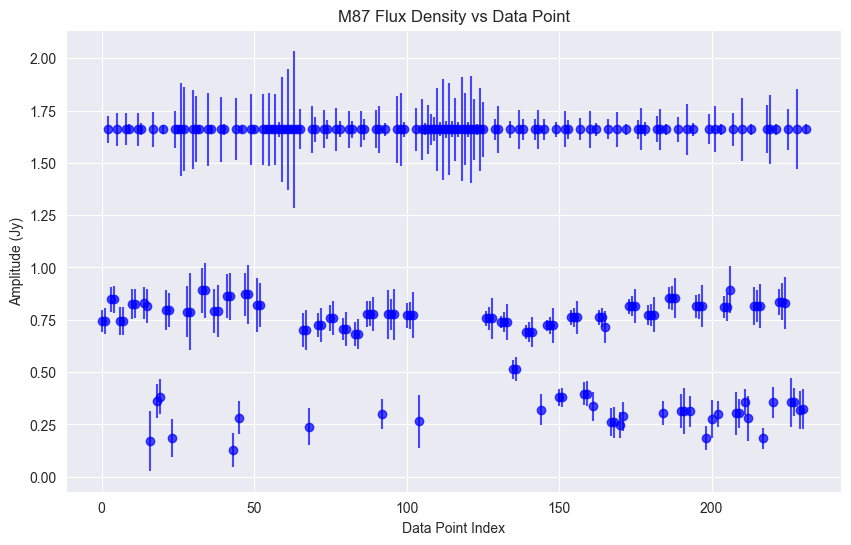

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Use the row index as x-axis
x = range(len(data))
y = data['amp']
yerr = data['sigma']

plt.errorbar(x, y, yerr=yerr, fmt='o', color='blue', alpha=0.7)
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude (Jy)')
plt.title('M87 Flux Density vs Data Point')
plt.grid(True)
plt.show()


In [3]:
import numpy as np

data['baseline'] = np.sqrt(data['u']**2 + data['v']**2)


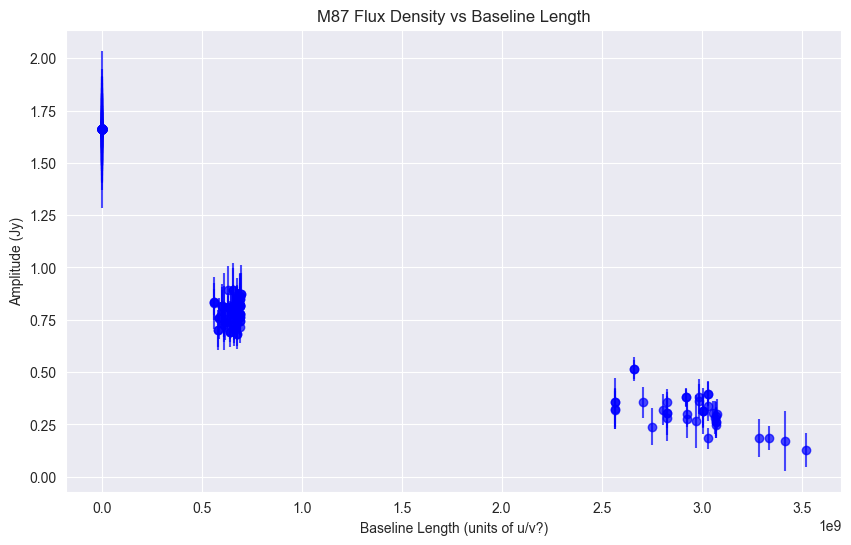

In [4]:
plt.figure(figsize=(10,6))

x = data['baseline']
y = data['amp']
yerr = data['sigma']

plt.errorbar(x, y, yerr=yerr, fmt='o', color='blue', alpha=0.7)
plt.xlabel('Baseline Length (units of u/v?)')
plt.ylabel('Amplitude (Jy)')
plt.title('M87 Flux Density vs Baseline Length')
plt.grid(True)
plt.show()


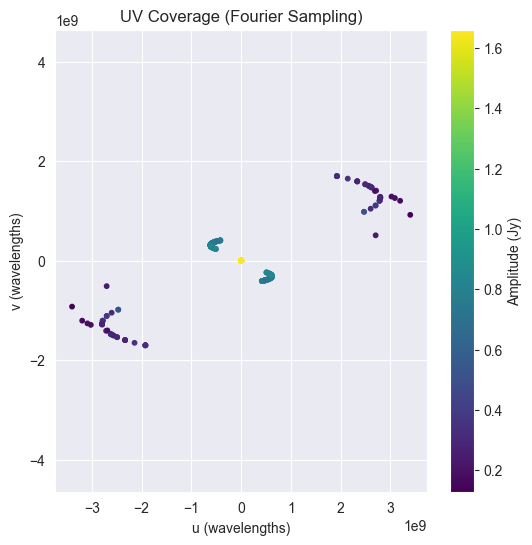

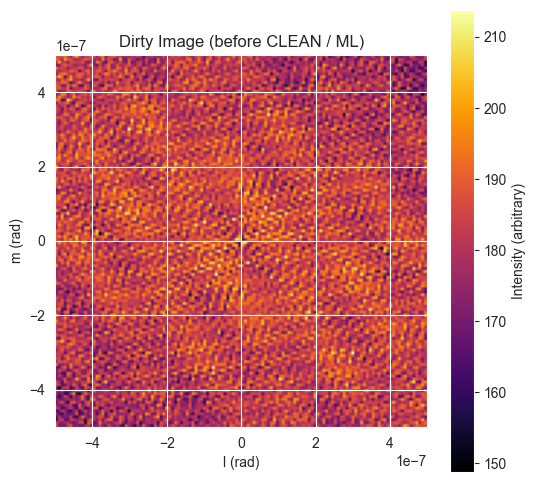

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assume your dataframe is called data with columns: u, v, amp
u = data['u'].values
v = data['v'].values
amp = data['amp'].values

# -------------------------------
# 1. Plot the uv-coverage (Fourier plane sampling)
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(u, v, c=amp, cmap='viridis', s=10)
plt.scatter(-u, -v, c=amp, cmap='viridis', s=10)  # add conjugates
plt.xlabel('u (wavelengths)')
plt.ylabel('v (wavelengths)')
plt.title('UV Coverage (Fourier Sampling)')
plt.colorbar(label='Amplitude (Jy)')
plt.axis('equal')
plt.show()

# -------------------------------
# 2. Create a simple "dirty image" with inverse FT
# -------------------------------
# Define image grid
N = 128   # resolution
fov = 1e-6  # field of view in radians (tune this)
l = np.linspace(-fov/2, fov/2, N)  # x-axis in radians
m = np.linspace(-fov/2, fov/2, N)  # y-axis in radians
L, M = np.meshgrid(l, m)

# Dirty image: sum over visibilities (no phase info -> approximate with amp)
image = np.zeros((N, N), dtype=complex)
for ui, vi, ai in zip(u, v, amp):
    phase = np.exp(2j*np.pi*(ui*L + vi*M))
    image += ai * phase

dirty_image = np.abs(image)

plt.figure(figsize=(6,6))
plt.imshow(dirty_image, extent=[l[0], l[-1], m[0], m[-1]], cmap='inferno')
plt.colorbar(label='Intensity (arbitrary)')
plt.title("Dirty Image (before CLEAN / ML)")
plt.xlabel("l (rad)")
plt.ylabel("m (rad)")
plt.show()


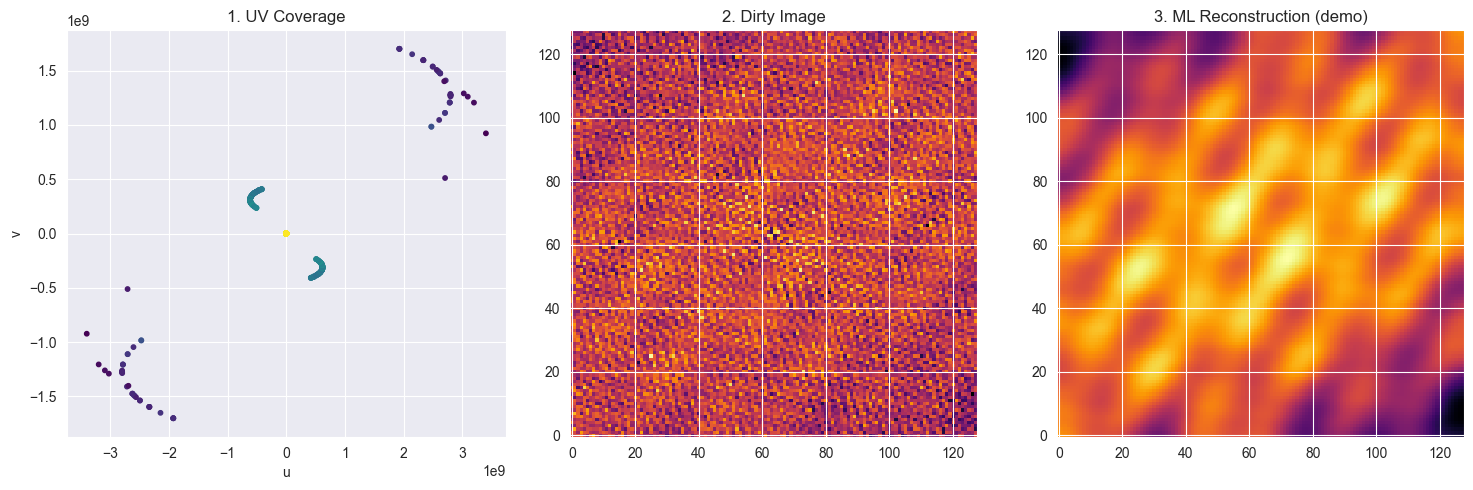

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# --- Assume you already computed dirty_image from the previous step ---

# 3. "After ML" (simple demonstration using denoising)
# In reality you'd train a deep net, but we'll simulate cleanup
ml_image = gaussian_filter(dirty_image, sigma=3)  # blur/denoise

# Plot all 3 stages
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Stage 1: uv coverage
axs[0].scatter(u, v, c=amp, cmap='viridis', s=10)
axs[0].scatter(-u, -v, c=amp, cmap='viridis', s=10)
axs[0].set_title("1. UV Coverage")
axs[0].set_xlabel("u")
axs[0].set_ylabel("v")

# Stage 2: dirty image
axs[1].imshow(dirty_image, cmap='inferno', origin='lower')
axs[1].set_title("2. Dirty Image")

# Stage 3: ML reconstruction (simulated)
axs[2].imshow(ml_image, cmap='inferno', origin='lower')
axs[2].set_title("3. ML Reconstruction (demo)")

plt.tight_layout()
plt.show()


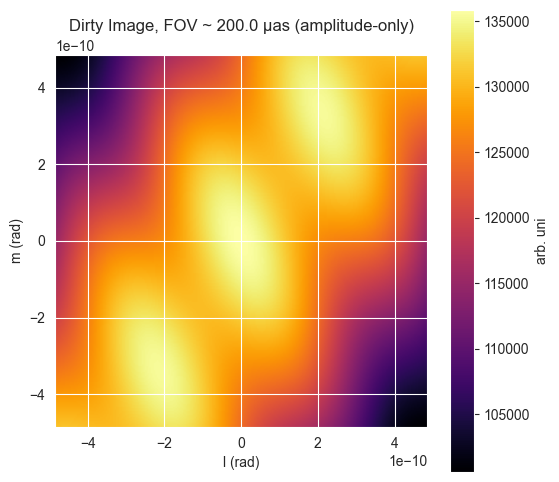

In [7]:
import numpy as np
import matplotlib.pyplot as plt

u = data['u'].values
v = data['v'].values
amp = data['amp'].values
w = 1.0 / (data['sigma'].values**2)  # inverse-variance weights

# 1) Proper FOV around the ring scale
fov_us = 200.0  # microarcseconds
fov = fov_us * 4.848e-12  # radians

# 2) Image grid (bump N if your machine can handle it)
N = 256
l = np.linspace(-fov/2, fov/2, N)
m = np.linspace(-fov/2, fov/2, N)
L, M = np.meshgrid(l, m)

# 3) Dirty image using amplitude-only (phase ~ 0) and weights
# NOTE: using amp * exp(i 2π (u l + v m)) assumes zero phases (not physically correct)
phase = np.exp(2j*np.pi*(np.outer(u, L.ravel()) + np.outer(v, M.ravel())))
vis_sum = (w * amp)[:, None] * phase  # broadcast over pixels
image = vis_sum.sum(axis=0).reshape(N, N)

dirty_image = np.abs(image)

plt.figure(figsize=(6,6))
plt.imshow(dirty_image, cmap='inferno', origin='lower',
           extent=[l[0], l[-1], m[0], m[-1]])
plt.xlabel('l (rad)'); plt.ylabel('m (rad)')
plt.title(f'Dirty Image, FOV ~ {fov_us} μas (amplitude-only)')
plt.colorbar(label='arb. uni')


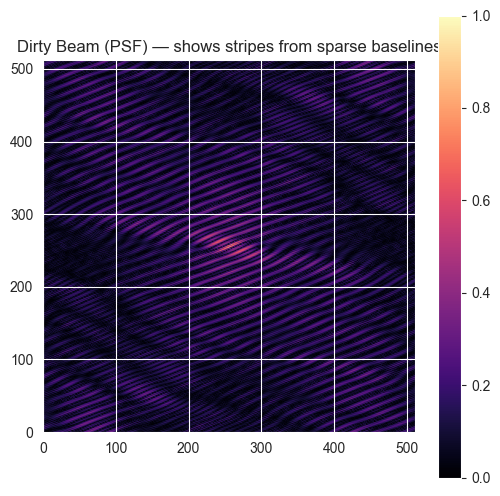

In [18]:
# Build sampling function S(u,v) as weighted deltas on a grid, then FFT to get PSF.
# Quick-and-dirty version: grid each (u,v) to nearest pixel and sum weights.
# (A proper gridding uses convolutional kernels like prolate spheroidal — this is a demo.)

# Choose uv grid to cover your max baseline
umax = np.max(np.abs(u)); vmax = np.max(np.abs(v))
Nu = 512
ug = np.linspace(-umax, umax, Nu)
vg = np.linspace(-vmax, vmax, Nu)
SU = np.zeros((Nu, Nu), dtype=float)

def nearest_idx(arr, val):
    return np.argmin(np.abs(arr - val))

for ui, vi, wi in zip(u, v, w):
    SU[nearest_idx(ug, ui), nearest_idx(vg, vi)] += wi
    SU[nearest_idx(ug, -ui), nearest_idx(vg, -vi)] += wi  # add conjugate

PSF = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(SU))))

plt.figure(figsize=(6,6))
plt.imshow(PSF/PSF.max(), origin='lower', cmap='magma')
plt.title('Dirty Beam (PSF) — shows stripes from sparse baselines')
plt.colorbar()
plt.show()


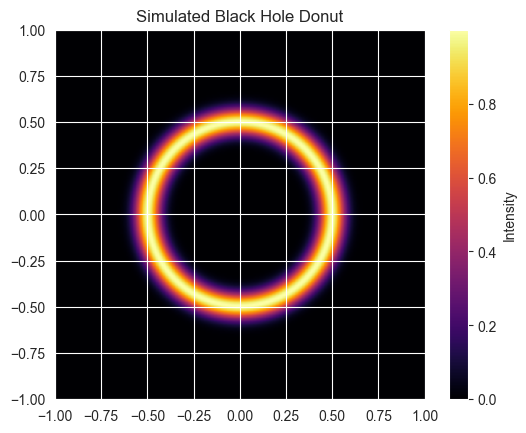

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a ring model (donut)
N = 256
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Create a ring
ring = np.exp(-((R-0.5)**2)/(2*0.05**2))

# Show the "true" black hole donut
plt.imshow(ring, cmap='inferno', extent=[-1,1,-1,1])
plt.colorbar(label="Intensity")
plt.title("Simulated Black Hole Donut")
plt.show()
